# Recommending neighborhoods in Austin, Texas

**What is the problem you are attempting to solve?**
As an immigrant and traveler, I know how hard it is to find a good neighborhood to live in, especially in an unfamiliar area or under a time restraint. Not many people love to do deep research. Also, one of the most popular questions on different forums is: “which area should I live with my family”. In this project, my goal is to assist people in recommending neighborhoods in Austin that meet their personalized needs. The application can collect user preferences by answering simple questions and then a list of recommended neighbors will be returned. 

**How is your solution valuable?**
My solution helps people guide through their search for a new home. This application will take into different user preferences such as accommodating family needs (certain schools or level crime) and their budget. Not only will this allow people to save time, but also make smarter decisions.  For those looking to buy a house as additional investment, the application will also have a feature that predicts house values. 

**What is your data source and how will you access it?**
I have 16 years of public crime reports from the Austin police department. This dataset contains a record of incidents that the Austin Police Department responded to and wrote a report.

Next is the real estate market. I am going to collect all addresses in Austin and surrounding areas from the County appraisal district (they are free to export) and going to use them to collect information about houses from the Zillow library (PyZillow) with free open Zillow API. Of course, there will be no personal information


In [1]:
import pandas as pd # 
import numpy as np
from pathlib import Path # importing files
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import metrics # Evaluation 
from sklearn import linear_model 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


from xgboost import XGBRegressor

# Detailed Austin Analysis

I am loading Data that have beed collected using PyZillow library with open Zillow API

In [2]:
# Open Files 
list_df = []
folder="Desktop/Zillow Data/API Data/"
for file in Path(folder).glob('*.csv'):
    df = pd.read_csv(file)
    list_df.append(df)
df_API = pd.concat(list_df)    

In [3]:
df_API

,Unnamed: 0,home_type,home_size,bathrooms,bedrooms,last_sold_date,last_sold_price,latitude,longitude,zestimate_amount,year_built,address,zipcode
0,0,SingleFamily,1.0,NaN,NaN,0,0.0,30.345961,-97.810160,371487.0,2001.0,4404 RIVERCREST DR TX,78746
1,1,SingleFamily,1714.0,2.0,NaN,0,0.0,30.283120,-97.801518,948283.0,1972.0,503 HONEYCOMB RDG TX,78746
2,2,SingleFamily,2045.0,2.0,4.0,0,0.0,30.277183,-97.789601,1276854.0,1982.0,3211 PARK HILLS DR TX,78746
3,3,SingleFamily,3018.0,4.0,NaN,0,0.0,30.281878,-97.787439,1292171.0,1984.0,3309 PARK HILLS DR TX,78746
4,4,SingleFamily,3352.0,3.5,5.0,0,0.0,30.288623,-97.839915,942203.0,1989.0,6500 MINIKAHDA CV TX,78746
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3535,3535,SingleFamily,2119.0,2.0,4.0,0,0.0,30.358768,-97.548586,245715.0,2003.0,11500 SHADY MEADOW WAY TX,78653
3536,3536,SingleFamily,1352.0,2.0,0.0,0,0.0,30.354156,-97.518881,202229.0,2016.0,13514 ABRAHAM LINCOLN ST TX,78653
3537,3537,SingleFamily,2640.0,3.0,4.0,0,0.0,30.357368,-97.541451,286959.0,2006.0,13829 LONG SHADOW DR TX,78653
3538,3538,SingleFamily,1730.0,2.0,4.0,0,0.0,30.351644,-97.511109,219056.0,2013.0,19401 TAYSHAS ST TX,78653


In [4]:
df_API['home_type'].unique()

array(['SingleFamily', 'Condominium', 'VacantResidentialLand',
       'Townhouse', 'MultiFamily2To4', 'Apartment', 'Duplex', 'Mobile',
       'Unknown', 'MultiFamily5Plus', 'Quadruplex', 'Miscellaneous'],
      dtype=object)

In [5]:
df_API[df_API['home_type'] == 'Miscellaneous']

,Unnamed: 0,home_type,home_size,bathrooms,bedrooms,last_sold_date,last_sold_price,latitude,longitude,zestimate_amount,year_built,address,zipcode
3099,3099,Miscellaneous,3423.0,3.5,4.0,0,0.0,30.272765,-97.788749,NaN,1994.0,1 GROVE CT AUSTIN TX,78746
3141,3141,Miscellaneous,5645.0,5.5,NaN,0,0.0,30.330901,-97.782789,NaN,1991.0,4111 LAKEPLACE LN TX,78746
3501,3501,Miscellaneous,1200.0,NaN,NaN,0,0.0,30.330354,-97.822967,NaN,1990.0,3007 RIVERCREST DR TX,78746
2233,2233,Miscellaneous,1455.0,2.0,0.0,0,0.0,30.448083,-97.656848,NaN,2002.0,1300 MISS ALLISONS WAY TX,78660
6901,6901,Miscellaneous,3180.0,3.5,4.0,0,0.0,30.449181,-97.568385,NaN,2006.0,4112 HIDDEN LAKE XING TX,78660
6929,6929,Miscellaneous,1860.0,2.5,3.0,0,0.0,30.428017,-97.636940,NaN,2006.0,1108 PEPPERMINT TRL TX,78660
2280,2280,Miscellaneous,1073.0,2.0,3.0,0,0.0,30.450315,-97.648087,NaN,1983.0,16036 FITCHBURG CIR TX,78660
3554,3554,Miscellaneous,1966.0,2.0,3.0,0,0.0,30.480420,-97.638557,274742.0,2006.0,1416 MUDDY WATERS DR TX,78660
5252,5252,Miscellaneous,1756.0,NaN,3.0,0,0.0,30.465548,-97.616045,NaN,2006.0,1508 KINGSTON LACY BLVD TX,78660
6404,6404,Miscellaneous,1.0,NaN,0.0,0,0.0,30.472876,-97.657551,NaN,NaN,17103 PRESTONS BRAID LN TX,78660


I will remove: VacantResidentialLand, Condominium, Mobile, Unknown, MultiFamily5Plus, Miscellaneous


In [6]:
df_API = df_API[(df_API['home_type']== 'SingleFamily')| (df_API['home_type']=='Townhouse')| (df_API['home_type']=='MultiFamily2To4')| (df_API['home_type']=='Apartment')| (df_API['home_type']=='Duplex')|(df_API['home_type']=='Quadruplex')]

In [7]:
df_API.sample(10)

,Unnamed: 0,home_type,home_size,bathrooms,bedrooms,last_sold_date,last_sold_price,latitude,longitude,zestimate_amount,year_built,address,zipcode
6966,6966,SingleFamily,2940.0,4.0,4.0,0,0.0,30.436703,-97.639918,309175.0,2000.0,853 SMOKE SIGNAL PASS TX,78660
1956,1956,SingleFamily,2428.0,3.0,4.0,0,0.0,30.445769,-97.565673,292276.0,2012.0,18312 LYDIA SPRINGS DR TX,78660
3686,3686,SingleFamily,1860.0,2.5,3.0,0,0.0,30.438518,-97.656886,248416.0,2002.0,1005 SWEET MELISSA DR TX,78660
5599,5599,SingleFamily,1907.0,2.5,3.0,0,0.0,30.467948,-97.635312,234553.0,1996.0,833 WHITEHALL DR TX,78660
5614,5614,SingleFamily,1763.0,2.0,NaN,0,0.0,30.151085,-97.784659,294943.0,2005.0,10204 WIND CAVE TRL TX,78747
805,805,SingleFamily,1314.0,2.0,0.0,NaN,NaN,30.357196,-97.518938,202315.0,2017.0,13911 THEODORE ROOSEVELT ST TX,78653
7705,7705,SingleFamily,2771.0,2.5,NaN,0,0.0,30.152688,-97.748858,286945.0,2008.0,8708 IPSWICH BAY DR TX,78747
3914,3914,SingleFamily,2434.0,3.0,4.0,0,0.0,30.277432,-97.789905,1336335.0,1981.0,3213 PARK HILLS DR TX,78746
5997,5997,SingleFamily,1772.0,2.0,4.0,0,0.0,30.462090,-97.645466,237933.0,1993.0,1239 BLACKTHORN DR TX,78660
1591,1591,SingleFamily,5048.0,4.5,NaN,0,0.0,30.307261,-97.855605,1302863.0,1992.0,8109 DANFORTH CV TX,78746


In [8]:
del df_API['Unnamed: 0']
del df_API['last_sold_date']
del df_API['last_sold_price']

I need to change the column name

In [9]:
df_API.rename(columns = {'address':'Address'}, inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [10]:
df_API

,home_type,home_size,bathrooms,bedrooms,latitude,longitude,zestimate_amount,year_built,Address,zipcode
0,SingleFamily,1.0,NaN,NaN,30.345961,-97.810160,371487.0,2001.0,4404 RIVERCREST DR TX,78746
1,SingleFamily,1714.0,2.0,NaN,30.283120,-97.801518,948283.0,1972.0,503 HONEYCOMB RDG TX,78746
2,SingleFamily,2045.0,2.0,4.0,30.277183,-97.789601,1276854.0,1982.0,3211 PARK HILLS DR TX,78746
3,SingleFamily,3018.0,4.0,NaN,30.281878,-97.787439,1292171.0,1984.0,3309 PARK HILLS DR TX,78746
4,SingleFamily,3352.0,3.5,5.0,30.288623,-97.839915,942203.0,1989.0,6500 MINIKAHDA CV TX,78746
...,...,...,...,...,...,...,...,...,...,...
3535,SingleFamily,2119.0,2.0,4.0,30.358768,-97.548586,245715.0,2003.0,11500 SHADY MEADOW WAY TX,78653
3536,SingleFamily,1352.0,2.0,0.0,30.354156,-97.518881,202229.0,2016.0,13514 ABRAHAM LINCOLN ST TX,78653
3537,SingleFamily,2640.0,3.0,4.0,30.357368,-97.541451,286959.0,2006.0,13829 LONG SHADOW DR TX,78653
3538,SingleFamily,1730.0,2.0,4.0,30.351644,-97.511109,219056.0,2013.0,19401 TAYSHAS ST TX,78653


In [11]:
df_API.isnull().sum()*100/df_API.isnull().count()


home_type            0.000000
home_size            0.488226
bathrooms            1.586735
bedrooms            40.719240
latitude             0.000000
longitude            0.000000
zestimate_amount     0.815695
year_built           0.768063
Address              0.000000
zipcode              0.000000
dtype: float64

Now I will load Data from Travis County

In [12]:
df_tra = pd.read_csv('Desktop/Zillow Data/df_travis.csv')

In [13]:
df_tra

,Unnamed: 0,index,Appraised Value,zipcodes,Address
0,0,0,"177,203",78653,12916 JAMES MADISON ST TX
1,1,119,"35,000",78653,EGGLESTON ST TX
2,2,121,"203,999",78653,13617 RICHARD NIXON ST MANOR TX
3,3,122,"228,677",78653,18905 GREAT FALLS DR TX
4,4,123,"210,457",78653,21339 BLAKE-MANOR RD TX
...,...,...,...,...,...
312922,328639,2621,"239,350",78664,17018 JIGSAW PATHWAY TX
312923,328640,2622,"218,592",78664,2812 BRIDEKIRK DR TX
312924,328641,2623,"242,546",78664,1600 BALMORHEA LN TX
312925,328642,2624,"285,012",78664,1349 AMISTAD DR TX


In [14]:

del df_tra['Unnamed: 0']
del df_tra['index']

In [15]:
df_tra

,Appraised Value,zipcodes,Address
0,"177,203",78653,12916 JAMES MADISON ST TX
1,"35,000",78653,EGGLESTON ST TX
2,"203,999",78653,13617 RICHARD NIXON ST MANOR TX
3,"228,677",78653,18905 GREAT FALLS DR TX
4,"210,457",78653,21339 BLAKE-MANOR RD TX
...,...,...,...
312922,"239,350",78664,17018 JIGSAW PATHWAY TX
312923,"218,592",78664,2812 BRIDEKIRK DR TX
312924,"242,546",78664,1600 BALMORHEA LN TX
312925,"285,012",78664,1349 AMISTAD DR TX


In [16]:
df_tra.isnull().sum()*100/df_tra.isnull().count()


Appraised Value    0.0
zipcodes           0.0
Address            0.0
dtype: float64

So we have 2 datasets: df_tra with price info and df_API with details about house. Now I want to merge those datasets into 1 

In [17]:
df_all = pd.merge(df_API,df_tra, on="Address", how = 'left')

In [18]:
df_all

,home_type,home_size,bathrooms,bedrooms,latitude,longitude,zestimate_amount,year_built,Address,zipcode,Appraised Value,zipcodes
0,SingleFamily,1.0,NaN,NaN,30.345961,-97.810160,371487.0,2001.0,4404 RIVERCREST DR TX,78746,"251,477",78746.0
1,SingleFamily,1714.0,2.0,NaN,30.283120,-97.801518,948283.0,1972.0,503 HONEYCOMB RDG TX,78746,"1,217,527",78746.0
2,SingleFamily,2045.0,2.0,4.0,30.277183,-97.789601,1276854.0,1982.0,3211 PARK HILLS DR TX,78746,"1,084,753",78746.0
3,SingleFamily,3018.0,4.0,NaN,30.281878,-97.787439,1292171.0,1984.0,3309 PARK HILLS DR TX,78746,"1,126,000",78746.0
4,SingleFamily,3352.0,3.5,5.0,30.288623,-97.839915,942203.0,1989.0,6500 MINIKAHDA CV TX,78746,"818,000",78746.0
...,...,...,...,...,...,...,...,...,...,...,...,...
33586,SingleFamily,2119.0,2.0,4.0,30.358768,-97.548586,245715.0,2003.0,11500 SHADY MEADOW WAY TX,78653,"239,500",78653.0
33587,SingleFamily,1352.0,2.0,0.0,30.354156,-97.518881,202229.0,2016.0,13514 ABRAHAM LINCOLN ST TX,78653,"193,622",78653.0
33588,SingleFamily,2640.0,3.0,4.0,30.357368,-97.541451,286959.0,2006.0,13829 LONG SHADOW DR TX,78653,"268,169",78653.0
33589,SingleFamily,1730.0,2.0,4.0,30.351644,-97.511109,219056.0,2013.0,19401 TAYSHAS ST TX,78653,"237,408",78653.0


In [19]:
df_all.isnull().sum()*100/df_all.isnull().count()


home_type            0.000000
home_size            0.488226
bathrooms            1.586735
bedrooms            40.719240
latitude             0.000000
longitude            0.000000
zestimate_amount     0.815695
year_built           0.768063
Address              0.000000
zipcode              0.000000
Appraised Value      0.458456
zipcodes             0.458456
dtype: float64

In [20]:
df_all = df_all.dropna(how='all', subset=['bedrooms', 'bathrooms'])

In [21]:
df_all = df_all.dropna(how='all', subset=['home_size', 'bathrooms', 'zestimate_amount'])

In [22]:
df_all = df_all.dropna(how='all', subset=['home_size', 'Appraised Value'])

In [23]:
df_all = df_all.dropna(subset=['Appraised Value'])

In [24]:
df_all.isnull().sum()*100/df_all.isnull().count()


home_type            0.000000
home_size            0.078590
bathrooms            0.541063
bedrooms            40.235166
latitude             0.000000
longitude            0.000000
zestimate_amount     0.586404
year_built           0.619654
Address              0.000000
zipcode              0.000000
Appraised Value      0.000000
zipcodes             0.000000
dtype: float64

I am going to fill up bedrooms using simple "Br = Bth + 1" formula

In [25]:
df_all.bedrooms = df_all.bedrooms.fillna(0)
df_all.bathrooms = df_all.bathrooms.fillna(0)
df_all['bathrooms'] = df_all['bathrooms'].apply(lambda x: int(x))
df_all['bedrooms'] = df_all['bedrooms'].apply(lambda x: int(x))
df_all['Beds'] = np.where(df_all['bedrooms'] == 0, df_all['bathrooms'] + 1, df_all['bedrooms'])
del df_all['bedrooms']

In [26]:
df_all.isnull().sum()*100/df_all.isnull().count()


home_type           0.000000
home_size           0.078590
bathrooms           0.000000
latitude            0.000000
longitude           0.000000
zestimate_amount    0.586404
year_built          0.619654
Address             0.000000
zipcode             0.000000
Appraised Value     0.000000
zipcodes            0.000000
Beds                0.000000
dtype: float64

In [27]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33083 entries, 1 to 33590
Data columns (total 12 columns):
home_type           33083 non-null object
home_size           33057 non-null float64
bathrooms           33083 non-null int64
latitude            33083 non-null float64
longitude           33083 non-null float64
zestimate_amount    32889 non-null float64
year_built          32878 non-null float64
Address             33083 non-null object
zipcode             33083 non-null int64
Appraised Value     33083 non-null object
zipcodes            33083 non-null float64
Beds                33083 non-null int64
dtypes: float64(6), int64(3), object(3)
memory usage: 3.3+ MB


In [28]:
df = df_all.dropna()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32676 entries, 1 to 33590
Data columns (total 12 columns):
home_type           32676 non-null object
home_size           32676 non-null float64
bathrooms           32676 non-null int64
latitude            32676 non-null float64
longitude           32676 non-null float64
zestimate_amount    32676 non-null float64
year_built          32676 non-null float64
Address             32676 non-null object
zipcode             32676 non-null int64
Appraised Value     32676 non-null object
zipcodes            32676 non-null float64
Beds                32676 non-null int64
dtypes: float64(6), int64(3), object(3)
memory usage: 3.2+ MB


### filling zestimate amount data with tricky mean

In [30]:
df

,home_type,home_size,bathrooms,latitude,longitude,zestimate_amount,year_built,Address,zipcode,Appraised Value,zipcodes,Beds
1,SingleFamily,1714.0,2,30.283120,-97.801518,948283.0,1972.0,503 HONEYCOMB RDG TX,78746,"1,217,527",78746.0,3
2,SingleFamily,2045.0,2,30.277183,-97.789601,1276854.0,1982.0,3211 PARK HILLS DR TX,78746,"1,084,753",78746.0,4
3,SingleFamily,3018.0,4,30.281878,-97.787439,1292171.0,1984.0,3309 PARK HILLS DR TX,78746,"1,126,000",78746.0,5
4,SingleFamily,3352.0,3,30.288623,-97.839915,942203.0,1989.0,6500 MINIKAHDA CV TX,78746,"818,000",78746.0,5
5,SingleFamily,3602.0,4,30.328302,-97.805591,929297.0,1989.0,3200 LOOKOUT LN TX,78746,"871,722",78746.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
33586,SingleFamily,2119.0,2,30.358768,-97.548586,245715.0,2003.0,11500 SHADY MEADOW WAY TX,78653,"239,500",78653.0,4
33587,SingleFamily,1352.0,2,30.354156,-97.518881,202229.0,2016.0,13514 ABRAHAM LINCOLN ST TX,78653,"193,622",78653.0,3
33588,SingleFamily,2640.0,3,30.357368,-97.541451,286959.0,2006.0,13829 LONG SHADOW DR TX,78653,"268,169",78653.0,4
33589,SingleFamily,1730.0,2,30.351644,-97.511109,219056.0,2013.0,19401 TAYSHAS ST TX,78653,"237,408",78653.0,4


In [31]:
df['zestimate_amount'] =df['zestimate_amount'].apply(lambda x: str(x)[:-2])
df['home_size'] =df['home_size'].apply(lambda x: str(x)[:4])
df['year_built'] =df['year_built'].apply(lambda x: str(x)[:4])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [32]:
df['zestimate_amount'] = df['zestimate_amount'].apply(lambda x: int(x))
df['Appraised Value'] = df['Appraised Value'].apply(lambda x: x.replace(',', ''))


df['Appraised Value'] = df['Appraised Value'].apply(lambda x: int(x))


del df['zipcodes']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [33]:
df['home_size'] = df['home_size'].apply(lambda x: x.replace('.', ''))

df['home_size'] =df['home_size'].apply(lambda x: int(x))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
df['year_built'] =df['year_built'].apply(lambda x: int(x))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
df.describe()

,home_size,bathrooms,latitude,longitude,zestimate_amount,year_built,zipcode,Appraised Value,Beds
count,32676.000000,32676.000000,32676.000000,32676.000000,3.267600e+04,32676.000000,32676.000000,3.267600e+04,32676.000000
mean,2396.911862,2.452962,30.353656,-97.664816,5.510328e+05,1998.597809,78691.833425,4.915389e+05,3.468234
std,1089.942334,1.993261,0.107826,0.108950,6.826493e+05,14.891769,43.031689,6.750871e+05,0.819166
min,10.000000,0.000000,29.569556,-98.361483,1.042660e+05,1850.000000,78653.000000,2.630000e+02,1.000000
25%,1652.750000,2.000000,30.282942,-97.785438,2.337428e+05,1988.000000,78660.000000,2.150840e+05,3.000000
50%,2135.500000,2.000000,30.356310,-97.635221,2.846615e+05,2002.000000,78660.000000,2.694615e+05,3.000000
75%,2823.000000,3.000000,30.452673,-97.568279,5.416748e+05,2009.000000,78746.000000,4.487170e+05,4.000000
max,9986.000000,321.000000,30.631018,-97.390341,1.316532e+07,2019.000000,78747.000000,4.225000e+07,16.000000


In [36]:
df.zipcode.unique()

array([78746, 78747, 78653, 78660, 78704])

# checking outliers 

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32676 entries, 1 to 33590
Data columns (total 11 columns):
home_type           32676 non-null object
home_size           32676 non-null int64
bathrooms           32676 non-null int64
latitude            32676 non-null float64
longitude           32676 non-null float64
zestimate_amount    32676 non-null int64
year_built          32676 non-null int64
Address             32676 non-null object
zipcode             32676 non-null int64
Appraised Value     32676 non-null int64
Beds                32676 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 3.0+ MB


In [38]:
numeric_columns = ['Appraised Value', 'zestimate_amount', 'bathrooms', 'Beds']

In [39]:
for col in numeric_columns:
    q75, q25 = np.percentile(df[col], [75 ,25])
    iqr = q75 - q25


    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    print("Number of outliers for {} is: {} and it is {} percent.".format(col, len((np.where((df[col] > max_val) 
                      | (df[col] < min_val))[0])), len((np.where((df[col] > max_val) | 
                                                    (df[col] < min_val))[0]))*100/1987))
   

Number of outliers for Appraised Value is: 5794 and it is 291.59536990437846 percent.
Number of outliers for zestimate_amount is: 4877 and it is 245.44539506794163 percent.
Number of outliers for bathrooms is: 1363 and it is 68.59587317564167 percent.
Number of outliers for Beds is: 808 and it is 40.66431806743835 percent.


Text(0.5, 1.0, 'bedrooms')

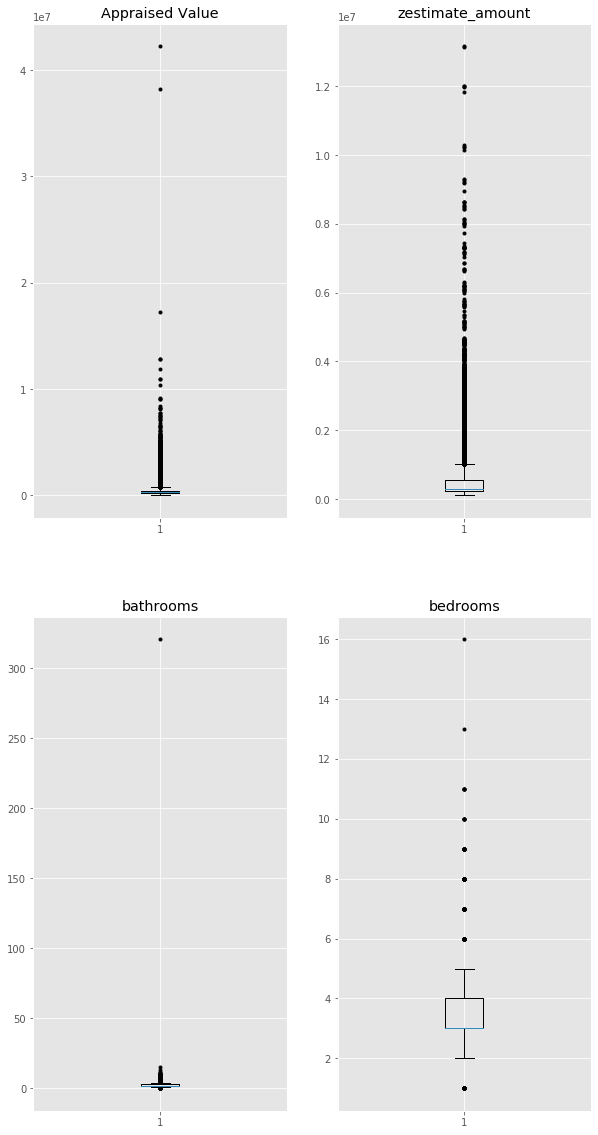

In [40]:
fig = plt.figure(figsize=(10,20))

plt.subplot(2, 2, 1)
plt.boxplot(df["Appraised Value"], sym='k.')
plt.title("Appraised Value")

plt.subplot(2, 2, 2)
plt.boxplot(df["zestimate_amount"], sym='k.')
plt.title("zestimate_amount")

plt.subplot(2, 2, 3)
plt.boxplot(df["bathrooms"], sym='k.')
plt.title("bathrooms")

plt.subplot(2, 2, 4)
plt.boxplot(df["Beds"], sym='k.')
plt.title("bedrooms")


In [41]:
df.drop(df[df['Appraised Value'] < 50000].index, inplace = True)
df.drop(df[df['bathrooms'] > 8].index, inplace = True)


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [42]:
df.drop(df[df['Appraised Value'] > 30000000].index, inplace = True)

Text(0.5, 1.0, 'bedrooms')

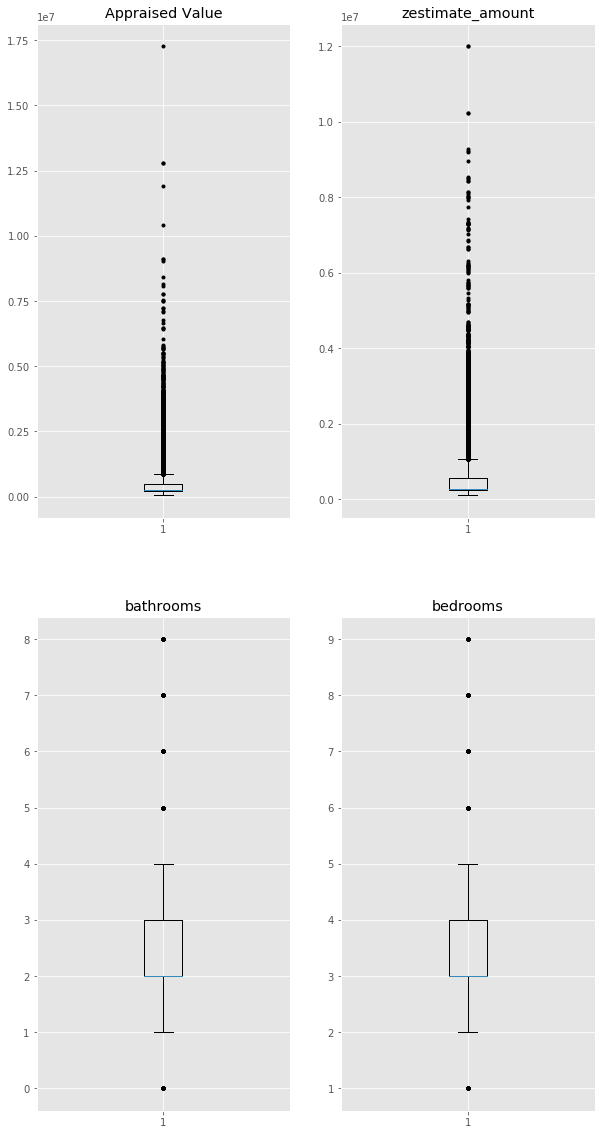

In [43]:
fig = plt.figure(figsize=(10,20))

plt.subplot(2, 2, 1)
plt.boxplot(df["Appraised Value"], sym='k.')
plt.title("Appraised Value")

plt.subplot(2, 2, 2)
plt.boxplot(df["zestimate_amount"], sym='k.')
plt.title("zestimate_amount")

plt.subplot(2, 2, 3)
plt.boxplot(df["bathrooms"], sym='k.')
plt.title("bathrooms")

plt.subplot(2, 2, 4)
plt.boxplot(df["Beds"], sym='k.')
plt.title("bedrooms")


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a231416d8>,
      dtype=object)

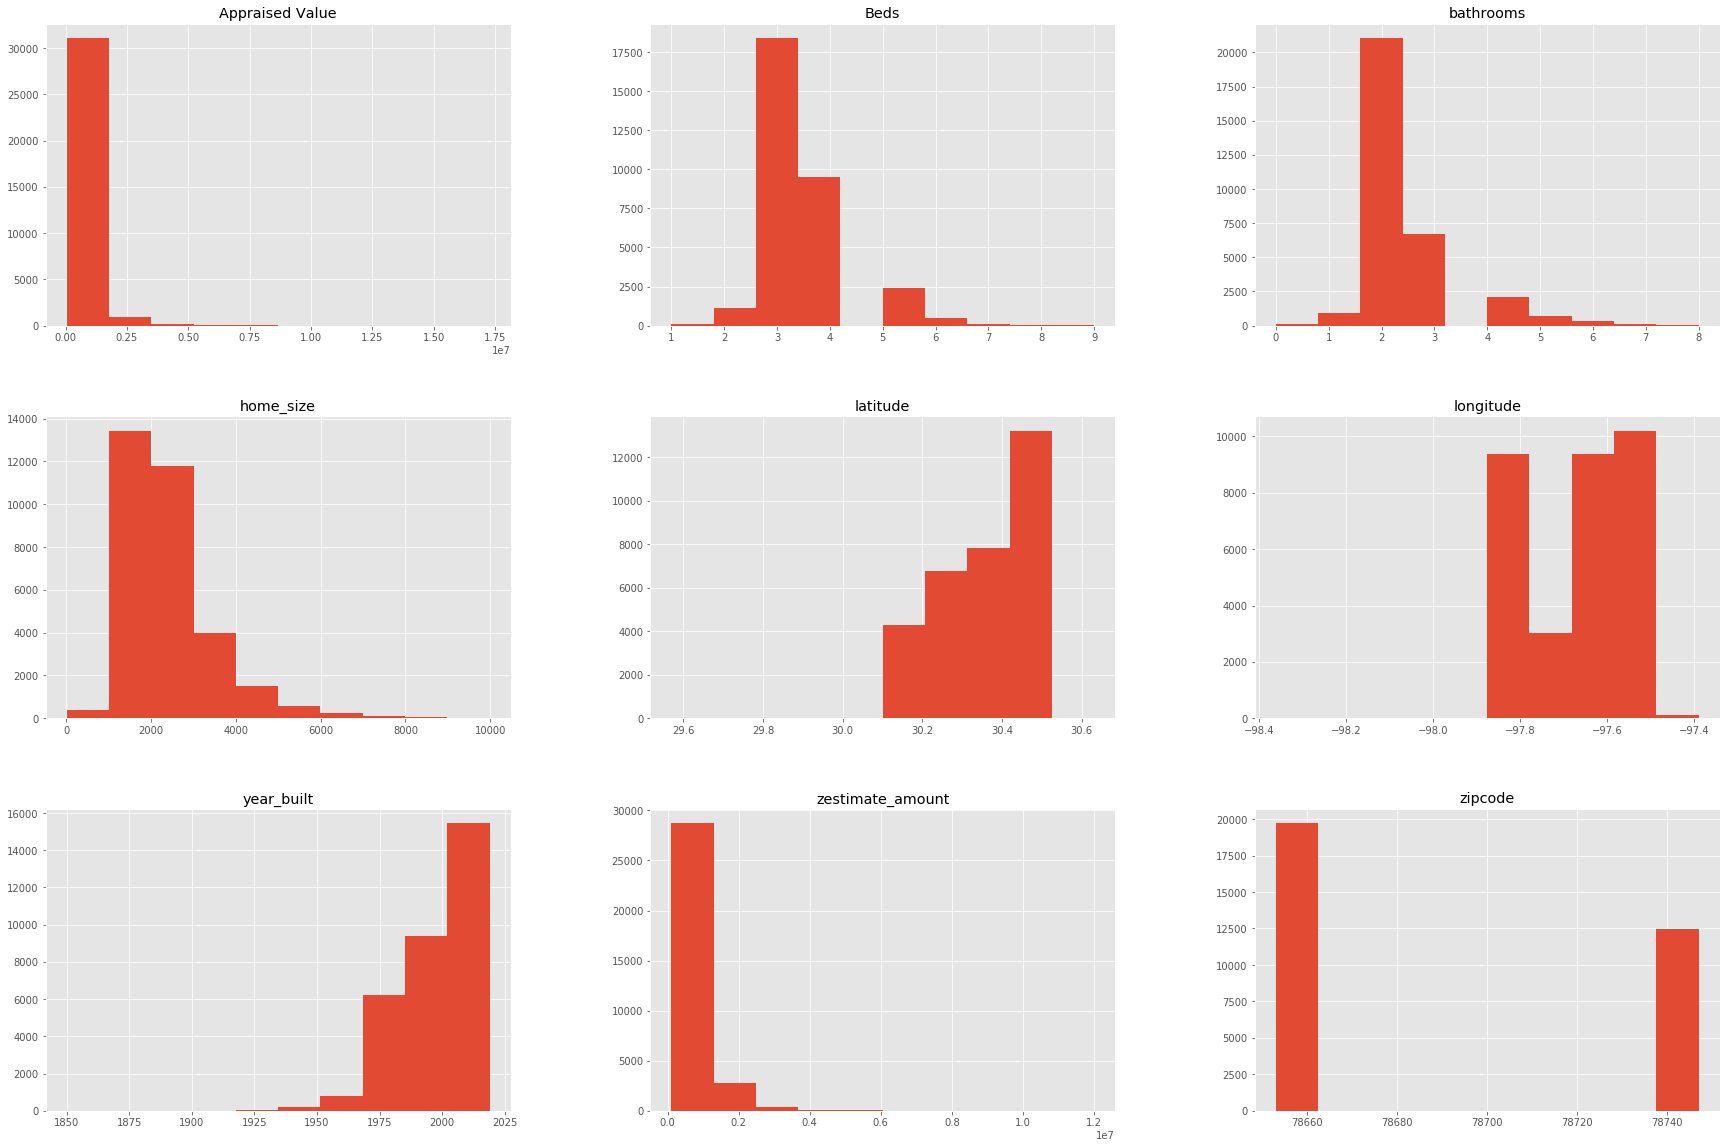

In [44]:
df.hist(figsize=(30,20))

In [45]:
import seaborn as sns

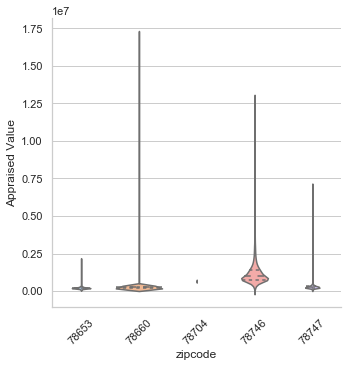

In [162]:
sns.set(style="whitegrid", palette="pastel")
g = sns.catplot(x="zipcode", y="Appraised Value",
            kind="violin",scale='count', inner='quartile', data=df);
plt.title('')

g.set_xticklabels(rotation=45)

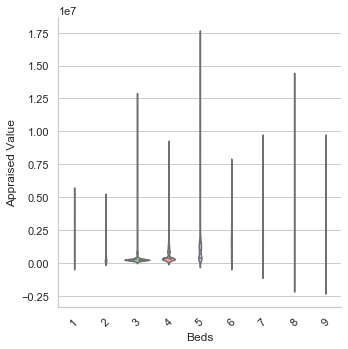

In [48]:
sns.set(style="whitegrid", palette="pastel")
g = sns.catplot(x="Beds", y="Appraised Value",
            kind="violin",scale='count', inner='quartile', data=df);
plt.title('')

g.set_xticklabels(rotation=45)

Text(0, 0.5, 'Counts')

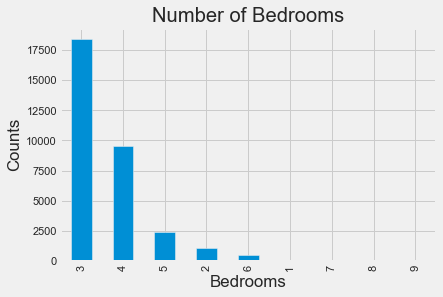

In [154]:
df.Beds.value_counts().plot(kind = 'bar')
plt.title('Number of Bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Counts')

#### Create correlation matrix for features

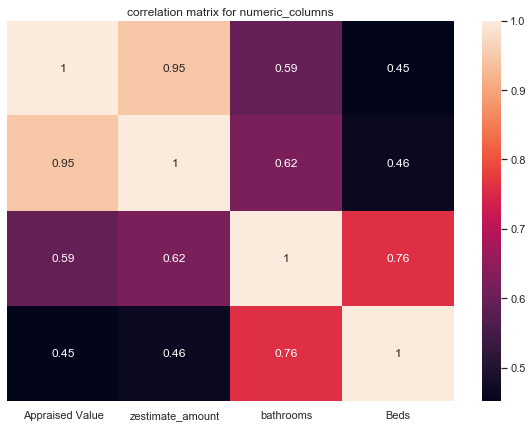

In [49]:
plt.figure(figsize=(10,7))
sns.heatmap(df[numeric_columns].corr(),  annot=True, xticklabels=1, yticklabels=0)
plt.title("correlation matrix for numeric_columns")
plt.show()

## Encoding

In [50]:
df_modeling = df.copy()

In [51]:
from sklearn import preprocessing 

In [52]:
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'country'. 
df_modeling['zipcode'] = label_encoder.fit_transform(df_modeling['zipcode']) 
df_modeling['home_type'] = label_encoder.fit_transform(df_modeling['home_type']) 

In [53]:
df_modeling

,home_type,home_size,bathrooms,latitude,longitude,zestimate_amount,year_built,Address,zipcode,Appraised Value,Beds
1,3,1714,2,30.283120,-97.801518,948283,1972,503 HONEYCOMB RDG TX,3,1217527,3
2,3,2045,2,30.277183,-97.789601,1276854,1982,3211 PARK HILLS DR TX,3,1084753,4
3,3,3018,4,30.281878,-97.787439,1292171,1984,3309 PARK HILLS DR TX,3,1126000,5
4,3,3352,3,30.288623,-97.839915,942203,1989,6500 MINIKAHDA CV TX,3,818000,5
5,3,3602,4,30.328302,-97.805591,929297,1989,3200 LOOKOUT LN TX,3,871722,4
...,...,...,...,...,...,...,...,...,...,...,...
33586,3,2119,2,30.358768,-97.548586,245715,2003,11500 SHADY MEADOW WAY TX,0,239500,4
33587,3,1352,2,30.354156,-97.518881,202229,2016,13514 ABRAHAM LINCOLN ST TX,0,193622,3
33588,3,2640,3,30.357368,-97.541451,286959,2006,13829 LONG SHADOW DR TX,0,268169,4
33589,3,1730,2,30.351644,-97.511109,219056,2013,19401 TAYSHAS ST TX,0,237408,4


## Feature ingeneering

1) I want to add additional feature: Price per sqft

2) to make sure the year make sence I want to replace 'year_built' with 'age of house'

In [54]:
df_modeling['house_age'] = 2018 - df_modeling['year_built']

In [55]:
df_modeling['price_sqft'] =  df_modeling['zestimate_amount'] / df_modeling['home_size'] 

In [56]:
df_modeling.sort_values('price_sqft')

,home_type,home_size,bathrooms,latitude,longitude,zestimate_amount,year_built,Address,zipcode,Appraised Value,Beds,house_age,price_sqft
9184,3,2910,2,30.160327,-97.743822,158421,2005,7905 RINGSBY CV TX,4,265400,4,13,54.440206
21990,3,4652,2,30.447625,-97.627705,277357,2003,404 EVENING GROSBEAK DR TX,1,357457,5,15,59.621023
31033,3,2028,2,30.344394,-97.554051,122870,1981,305 BROWNING ST TX,0,190702,4,37,60.586785
16124,3,5383,4,30.448977,-97.626865,377086,2002,508 EVENING GROSBEAK DR TX,1,373093,5,16,70.051273
18857,3,1984,2,30.457632,-97.635586,139185,1992,16910 DASHWOOD CREEK DR TX,1,227000,3,26,70.153730
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27157,3,40,5,30.307521,-97.786219,3475796,2006,4117 RIVER GARDEN TRL TX,3,3083416,5,12,86894.900000
3432,3,10,4,30.306245,-97.862722,1187841,1978,907 CRYSTAL CREEK DR TX,3,1214377,5,40,118784.100000
2931,3,10,3,30.278382,-97.785226,1301181,1983,3009 HATLEY DR TX,3,1275021,4,35,130118.100000
1733,3,10,2,30.314630,-97.787627,1747313,1900,2900 SPARKLING BROOK LN AUSTIN TX,3,1585000,1,118,174731.300000


In [57]:
del df_modeling['latitude']
del df_modeling['longitude']
del df_modeling['Address']

In [58]:
Y = df_modeling['Appraised Value']
# X is the feature set
X = df_modeling.drop(['Appraised Value', 'year_built','zestimate_amount'], axis=1)

In [59]:
X

,home_type,home_size,bathrooms,zipcode,Beds,house_age,price_sqft
1,3,1714,2,3,3,46,553.257293
2,3,2045,2,3,4,36,624.378484
3,3,3018,4,3,5,34,428.154738
4,3,3352,3,3,5,29,281.086814
5,3,3602,4,3,4,29,257.994725
...,...,...,...,...,...,...,...
33586,3,2119,2,0,4,15,115.957999
33587,3,1352,2,0,3,2,149.577663
33588,3,2640,3,0,4,12,108.696591
33589,3,1730,2,0,4,5,126.621965


In [60]:
from sklearn.preprocessing import StandardScaler

#scal = StandardScaler()
 
#scal.fit(X)
#X_st = scal.transform(X)

#scaled_features = StandardScaler().fit_transform(df_modeling.values)
#X_st = pd.DataFrame(X_st, index=X.index, columns=X.columns)

In [61]:
#X_st

In [62]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 25719
The number of observations in test set is 6430


# Modeling

We will compare five different machine learning models using the great Scikit-Learn library:
1) Linear Regression
2) Support Vector Machine Regression
3) Random Forest Regression
4) Gradient Boosting Regression
5) K-Nearest Neighbors Regression

In [63]:
# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import r2_score

*R-squared* is a statistical measure of how close the data are to the fitted regression line. It is also known as the coefficient of determination, or the coefficient of multiple determination for multiple regression.

In [64]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))
def fit_and_predict(model):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    R2 = model.score(X_train, y_train)
    model_mae = mae(y_test, model_pred)
    cv = ShuffleSplit(n_splits=7, test_size=0.3, random_state=0)
    accuracies = cross_val_score(estimator=model, X=X_train, y=y_train,cv=cv)
    print("R-squared of the model in training set is: {}\n".format(R2),'Cross_val: {}\n'.format(accuracies),'Mean absolute error of the prediction is: {}'.format(model_mae))
    # Return the performance metric
    return model_mae

## Model 1: linear Regression


In [65]:
lr = LinearRegression()
lr_mae = fit_and_predict(lr)


R-squared of the model in training set is: 0.5556976451566373
 Cross_val: [0.59214667 0.49371082 0.51338572 0.55254017 0.56819939 0.5767901
 0.57934684]
 Mean absolute error of the prediction is: 202897.7277394253


In [66]:
DT = DecisionTreeRegressor(random_state=0)
dt_mae = fit_and_predict(DT)

R-squared of the model in training set is: 0.9998469703855927
 Cross_val: [0.69562659 0.80366867 0.81152924 0.71409702 0.8966088  0.71000079
 0.86678543]
 Mean absolute error of the prediction is: 60602.720878693624


In [67]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_predict(random_forest)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


R-squared of the model in training set is: 0.9787553034737243
 Cross_val: [0.87818583 0.82522075 0.83448267 0.8937228  0.92940829 0.89855645
 0.92008778]
 Mean absolute error of the prediction is: 48105.5778758424


In [68]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_predict(gradient_boosted)

R-squared of the model in training set is: 0.9334368262278072
 Cross_val: [0.91153973 0.82851574 0.84300212 0.89767937 0.92147415 0.9146072
 0.92226323]
 Mean absolute error of the prediction is: 53116.06172564835


In [69]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_predict(knn)

R-squared of the model in training set is: 0.9001040043531146
 Cross_val: [0.92289993 0.81202486 0.8272309  0.89313681 0.90846454 0.91645347
 0.91334786]
 Mean absolute error of the prediction is: 53195.312706065444


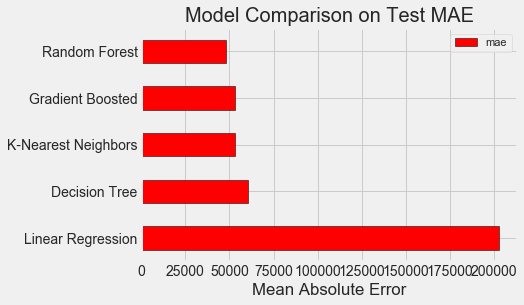

In [70]:
plt.style.use('fivethirtyeight')
#figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Decision Tree', 
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae,dt_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

In [72]:
final_model = RandomForestRegressor(random_state=60)
final_model.fit(X_train, y_train)
final_pred = final_model.predict(X)


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


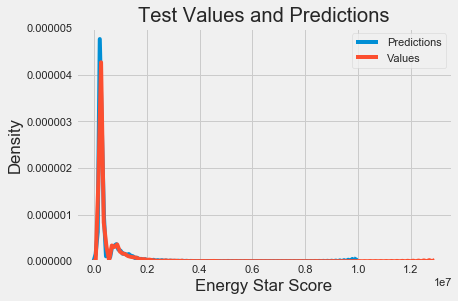

In [73]:

# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

In [74]:
len(final_pred)

32149

In [75]:
final_pred

array([1217527. , 1072186.1, 1126000. , ...,  275600.8,  230101. ,
        238968.9])

In [ ]:
result

In [ ]:
#y_new_inverse = scal.inverse_transform(X_st)
# scal.inverse_transform(y)

In [121]:
df['predicted value'] = final_pred


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [122]:
df

,home_type,home_size,bathrooms,latitude,longitude,zestimate_amount,year_built,Address,zipcode,Appraised Value,Beds,predicted value
1,SingleFamily,1714,2,30.283120,-97.801518,948283,1972,503 HONEYCOMB RDG TX,78746,1217527,3,1217527.0
2,SingleFamily,2045,2,30.277183,-97.789601,1276854,1982,3211 PARK HILLS DR TX,78746,1084753,4,1072186.1
3,SingleFamily,3018,4,30.281878,-97.787439,1292171,1984,3309 PARK HILLS DR TX,78746,1126000,5,1126000.0
4,SingleFamily,3352,3,30.288623,-97.839915,942203,1989,6500 MINIKAHDA CV TX,78746,818000,5,818000.0
5,SingleFamily,3602,4,30.328302,-97.805591,929297,1989,3200 LOOKOUT LN TX,78746,871722,4,871722.0
...,...,...,...,...,...,...,...,...,...,...,...,...
33586,SingleFamily,2119,2,30.358768,-97.548586,245715,2003,11500 SHADY MEADOW WAY TX,78653,239500,4,237460.0
33587,SingleFamily,1352,2,30.354156,-97.518881,202229,2016,13514 ABRAHAM LINCOLN ST TX,78653,193622,3,195844.4
33588,SingleFamily,2640,3,30.357368,-97.541451,286959,2006,13829 LONG SHADOW DR TX,78653,268169,4,275600.8
33589,SingleFamily,1730,2,30.351644,-97.511109,219056,2013,19401 TAYSHAS ST TX,78653,237408,4,230101.0


In [123]:
df['predicted value'] =df['predicted value'].apply(lambda x: str(x)[:-2])


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [124]:
df['predicted value'] = df['predicted value'].apply(lambda x: x.replace('.', ''))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [125]:
df['predicted value'] = df['predicted value'].apply(lambda x: int(x))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [144]:
df.sort_values('predicted value')

,home_type,home_size,bathrooms,latitude,longitude,zestimate_amount,year_built,Address,zipcode,Appraised Value,Beds,predicted value
25935,SingleFamily,984,1,30.280337,-97.491187,165994,1986,20605 DELORIO ST TX,78653,58960,2,58997
8556,SingleFamily,840,1,30.148541,-97.763288,175913,1979,9605 CHERYL LYNN RD TX,78747,53328,2,62748
4735,SingleFamily,800,1,30.116683,-97.698976,163096,1978,10104 SHIVELY LN TX,78747,93799,2,62748
25599,SingleFamily,984,1,30.281111,-97.487732,160876,1987,20815 VERNA ST TX,78653,56261,2,63954
33039,SingleFamily,636,1,30.462318,-97.470716,196257,1986,20101 BURR OAK DR TX,78653,65121,2,64560
...,...,...,...,...,...,...,...,...,...,...,...,...
11590,SingleFamily,3028,4,30.470772,-97.569335,382236,2018,20020 MOORLYNCH AVE TX,78660,384525,4,333665483333333
21576,SingleFamily,2439,2,30.437765,-97.626641,339088,2003,500 W WALTER AVE TX,78660,384932,3,354518266666666
5265,SingleFamily,2601,3,30.148420,-97.788978,392198,2006,10616 BIG THICKET DR TX,78747,360100,4,367666733333333
7635,SingleFamily,2601,2,30.153806,-97.787789,385122,2006,10133 ANAHUAC TRL TX,78747,354415,3,374561933333333


In [145]:
temp = df.groupby(['zipcode', 'Beds'])['Appraised Value'].mean().sort_values(ascending=False).reset_index()


In [146]:
temp

,zipcode,Beds,Appraised Value
0,78746,9,4.075620e+06
1,78746,8,3.184992e+06
2,78746,7,2.421362e+06
3,78746,6,2.058251e+06
4,78746,5,1.540357e+06
5,78746,1,1.426837e+06
6,78746,4,1.154305e+06
7,78746,3,9.073970e+05
8,78746,2,8.814831e+05
9,78704,3,6.491203e+05


In [159]:
df2 = temp.pivot(index = "zipcode", columns = "Beds", values = ['Appraised Value'])
#df.pivot(index ='A', columns ='B', values =['C', 'A']) 

In [160]:
df2

Appraised Value                                              \
Beds                  1              2              3             4   
zipcode                                                               
78653      1.720161e+05  162836.054441  206309.706798  2.462556e+05   
78660      2.272601e+05  216646.461538  240457.828230  2.926322e+05   
78704               NaN            NaN  649120.333333           NaN   
78746      1.426837e+06  881483.107266  907396.997345  1.154305e+06   
78747      2.985668e+05  194074.709360  264016.913688  3.196461e+05   

                                                                               
Beds                5             6             7             8             9  
zipcode                                                                        
78653    3.162641e+05  3.787990e+05  2.607450e+05           NaN           NaN  
78660    3.619200e+05  3.488043e+05  3.731860e+05           NaN  3.009900e+05  
78704             NaN           NaN           NaN           NaN           NaN  
78746    1.540357e+06  2.058251e+06  2.421362e+06  3.184992e+06  4.075620e+06  
78747    3.540669e+05  4.461457e+05  5.435840e+05           NaN           NaN

In [150]:
df2.to_csv('house_prices.csv')

In [163]:
df

,home_type,home_size,bathrooms,latitude,longitude,zestimate_amount,year_built,Address,zipcode,Appraised Value,Beds,predicted value
1,SingleFamily,1714,2,30.283120,-97.801518,948283,1972,503 HONEYCOMB RDG TX,78746,1217527,3,1217527
2,SingleFamily,2045,2,30.277183,-97.789601,1276854,1982,3211 PARK HILLS DR TX,78746,1084753,4,1072186
3,SingleFamily,3018,4,30.281878,-97.787439,1292171,1984,3309 PARK HILLS DR TX,78746,1126000,5,1126000
4,SingleFamily,3352,3,30.288623,-97.839915,942203,1989,6500 MINIKAHDA CV TX,78746,818000,5,818000
5,SingleFamily,3602,4,30.328302,-97.805591,929297,1989,3200 LOOKOUT LN TX,78746,871722,4,871722
...,...,...,...,...,...,...,...,...,...,...,...,...
33586,SingleFamily,2119,2,30.358768,-97.548586,245715,2003,11500 SHADY MEADOW WAY TX,78653,239500,4,237460
33587,SingleFamily,1352,2,30.354156,-97.518881,202229,2016,13514 ABRAHAM LINCOLN ST TX,78653,193622,3,195844
33588,SingleFamily,2640,3,30.357368,-97.541451,286959,2006,13829 LONG SHADOW DR TX,78653,268169,4,275600
33589,SingleFamily,1730,2,30.351644,-97.511109,219056,2013,19401 TAYSHAS ST TX,78653,237408,4,230101


In [164]:
df.to_csv('houseprise.csv')